In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [3]:
!ls gcs/dc-image-datasets-us-central1/synthetic_train

Defect	Pass


In [4]:
train_dir = os.path.join(f'gcs/dc-image-datasets-us-central1', 'synthetic_train')
validation_dir = os.path.join(f'gcs/dc-image-datasets-us-central1', 'synthetic_val')
test_dir = os.path.join(f'gcs/dc-image-datasets-us-central1', 'synthetic_test')
real_train_dir = os.path.join(f'gcs/dc-image-datasets-us-central1', 'real_train')
real_validation_dir = os.path.join(f'gcs/dc-image-datasets-us-central1', 'real_val')
real_test_dir = os.path.join(f'gcs/dc-image-datasets-us-central1', 'real_test')

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (512, 512) #512 x 512 pixel size is standard for synthetic training data

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

real_train_dataset = tf.keras.utils.image_dataset_from_directory(real_train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

real_validation_dataset = tf.keras.utils.image_dataset_from_directory(real_validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

real_test_dataset = tf.keras.utils.image_dataset_from_directory(real_test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1600 files belonging to 2 classes.


2022-12-09 16:22:51.012849: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-09 16:22:51.012965: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-09 16:22:51.012994: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (transferlearningv1): /proc/driver/nvidia/version does not exist
2022-12-09 16:22:51.013697: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 1200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [7]:
class_names = train_dataset.class_names

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

2022-12-09 16:23:25.811012: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 805306368 exceeds 10% of free system memory.
2022-12-09 16:23:25.932449: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 805306368 exceeds 10% of free system memory.
2022-12-09 16:23:26.121198: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 805306368 exceeds 10% of free system memory.
2022-12-09 16:23:26.240372: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 811610112 exceeds 10% of free system memory.


In [13]:
base_model.trainable = False

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
# If you have more than 2 x classification levels, edit this cell! 
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(512, 512, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# Step #1 - add all of the images into the training dataset
# Step #2 - bulk up the VM so that it can train faster.

initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

2022-12-09 16:26:50.105951: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 805306368 exceeds 10% of free system memory.


7/7 [==============================] - 22s 2s/step - loss: 0.7335 - accuracy: 0.5150


In [20]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
50/50 [==============================] - 162s 3s/step - loss: 0.7279 - accuracy: 0.4869 - val_loss: 0.7019 - val_accuracy: 0.5050
Epoch 2/10
50/50 [==============================] - 154s 3s/step - loss: 0.7087 - accuracy: 0.4963 - val_loss: 0.6980 - val_accuracy: 0.5150
Epoch 3/10
50/50 [==============================] - 157s 3s/step - loss: 0.7019 - accuracy: 0.5113 - val_loss: 0.6942 - val_accuracy: 0.5150
Epoch 4/10
50/50 [==============================] - 154s 3s/step - loss: 0.7024 - accuracy: 0.4869 - val_loss: 0.6905 - val_accuracy: 0.5150
Epoch 5/10
50/50 [==============================] - 159s 3s/step - loss: 0.6974 - accuracy: 0.5106 - val_loss: 0.6868 - val_accuracy: 0.5150
Epoch 6/10
50/50 [==============================] - 160s 3s/step - loss: 0.6916 - accuracy: 0.5206 - val_loss: 0.6832 - val_accuracy: 0.5200
Epoch 7/10
50/50 [==============================] - 154s 3s/step - loss: 0.6844 - accuracy: 0.5331 - val_loss: 0.6800 - val_accuracy: 0.5150
Epoch 8/10
50

In [21]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy

7/7 [==============================] - 22s 2s/step - loss: 0.6725 - accuracy: 0.5250


(0.6724671721458435, 0.5249999761581421)

In [22]:
loss, accuracy = model.evaluate(real_test_dataset)
loss, accuracy

7/7 [==============================] - 23s 2s/step - loss: 0.5481 - accuracy: 0.6600


(0.5481200218200684, 0.6600000262260437)

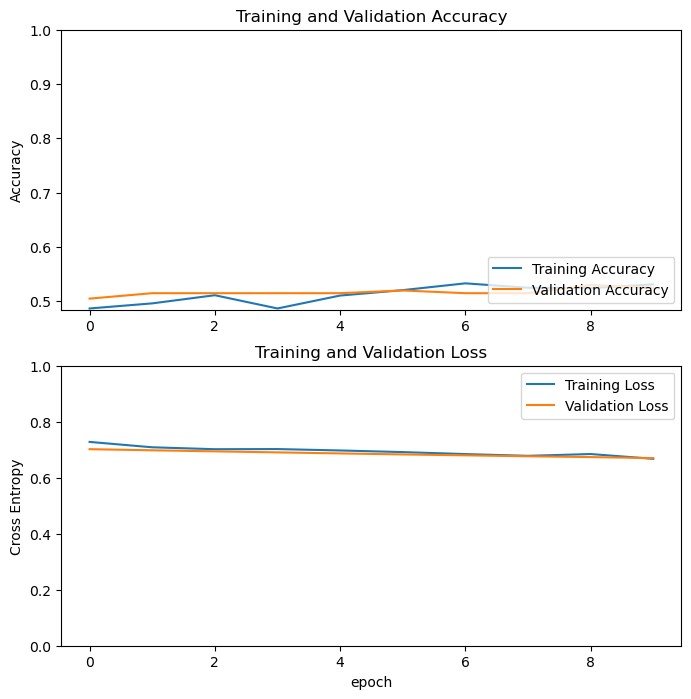

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()